# SVR-SARIMA hybrid model

In [ ]:
!pip install geneticalgorithm

## Step 1. SVR

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from geneticalgorithm import geneticalgorithm as ga #遗传算法
from sklearn.svm import SVR #支持向量回归模型 高效的非线性回归
import joblib #保存和加载库。在训练模型后，可以用 joblib 将模型保存成文件，以便在之后的代码或不同环境中加载使用，避免重复训练
from math import sqrt #用于求RMSE
import warnings
warnings.filterwarnings("ignore") #可以暂时忽略运行时的警告，减少控制台输出杂乱
from sklearn.preprocessing import StandardScaler #标准化

In [ ]:
# 定义超参数搜索范围
varbound = np.array([
    [1e-4, 1e3],    # C: 连续型, 正则化参数
    [1e-5, 1],      # epsilon: 连续型, 误差的宽容度
    [1e-6, 1],      # gamma: 连续型, 核函数的系数 (仅在非线性核函数时有效)
    [1, 5],         # degree: 整数型, 多项式核的阶数 (仅在 'poly' 核时有效)
    [0, 3],         # kernel: 整数型, 核函数选择 (0-线性, 1-多项式, 2-RBF, 3-Sigmoid)
    [0, 1]          # shrinking: 整数型, 收缩启发式 (0-False, 1-True)
])

vartype = np.array([
    ['real'],       # C
    ['real'],       # epsilon
    ['real'],       # gamma
    ['int'],        # degree
    ['int'],        # kernel (用整数0-3分别代表不同的核函数)
    ['int']         # shrinking (0代表False, 1代表True)
])

# 遗传算法参数
algorithm_param = {
    'max_num_iteration': 50,
    'population_size': 20,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 10
}

# 初始化全局变量用于存储最佳模型和准确率
best_score = 0
best_model = None

In [3]:
# import data
df = pd.read_csv("/content/Air Traffic Statistics.csv")
df['Date'] = df['Year'].astype(str) + '-' + df['Month']
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] < '2020-01-01']

X = {}
for i in range(1,13):
    X[f'yt-{i}'] = df['Aircraft Total'].squeeze().shift(i)

X = pd.DataFrame(X)
X.dropna(inplace=True)
y = df['Aircraft Total'][12:]
y.columns = 'Aircraft Total'

print(X.head)
print(y.head)

# 初始化 scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


# 训练、测试数据集
X_train_scaled, X_test_scaled = X_scaled[:216], X_scaled[216:]
y_train_scaled, y_test_scaled = y_scaled[:216], y_scaled[216:]


<bound method NDFrame.head of         yt-1     yt-2     yt-3     yt-4     yt-5     yt-6     yt-7     yt-8  \
12   14120.0  13478.0  14239.0  13654.0  14389.0  13891.0  13095.0  13570.0   
13   13612.0  14120.0  13478.0  14239.0  13654.0  14389.0  13891.0  13095.0   
14   13234.0  13612.0  14120.0  13478.0  14239.0  13654.0  14389.0  13891.0   
15   13823.0  13234.0  13612.0  14120.0  13478.0  14239.0  13654.0  14389.0   
16   13989.0  13823.0  13234.0  13612.0  14120.0  13478.0  14239.0  13654.0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
259  36853.0  35300.0  36313.0  35666.0  36752.0  32436.0  36534.0  37104.0   
260  35677.0  36853.0  35300.0  36313.0  35666.0  36752.0  32436.0  36534.0   
261  33398.0  35677.0  36853.0  35300.0  36313.0  35666.0  36752.0  32436.0   
262  34339.0  33398.0  35677.0  36853.0  35300.0  36313.0  35666.0  36752.0   
263  32528.0  34339.0  33398.0  35677.0  36853.0  35300.0  36313.0  35666.0   

        yt-9    yt-10

In [ ]:
def fun(par):
    # MLR超参数提取
    # 将 kernel 和 shrinking 的值映射到实际参数
    kernel_map = {0: 'linear', 1: 'poly', 2: 'rbf', 3: 'sigmoid'}
    shrinking_map = {0: False, 1: True}

    C = par[0]
    epsilon = par[1]
    gamma = par[2]
    degree = int(par[3])
    kernel = kernel_map[int(par[4])]
    shrinking = shrinking_map[int(par[5])]

    # 构建并训练 SVR 模型
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, degree=degree, kernel=kernel, shrinking=shrinking)

    model.fit(X_train_scaled, y_train_scaled)

    y_train_scaled_pred = model.predict(X_train_scaled)
    y_test_scaled_pred = model.predict(X_test_scaled)

    # 获得score
    # R2越大越好，而 MAE和RMSE越小越好
    R2_train = r2_score(y_train_scaled_pred, y_train_scaled)
    MAE_train = mean_absolute_error(y_train_scaled_pred, y_train_scaled)
    RMSE_train = sqrt(mean_squared_error(y_train_scaled_pred, y_train_scaled))

    R2_test = r2_score(y_test_scaled_pred, y_test_scaled)
    MAE_test = mean_absolute_error(y_test_scaled_pred, y_test_scaled)
    RMSE_test = sqrt(mean_squared_error(y_test_scaled_pred, y_test_scaled))

    # 计算综合得分
    # score 的值越大，表示模型在训练集和测试集上都具有更高的拟合度和更小的误差
    # 将R2和误差平衡为一个“性价比”得分，尽量提高R2的同时减少 MAE 和 RMSE
    score = (w1 * R2_test + w2 * R2_train) / (1 + w3 * RMSE_test + w4 * MAE_test + w5 * RMSE_train + w6 * MAE_train)

    # 保存最优模型（根据准确率优化）
    global best_score, best_model
    if score > best_score:
        best_score = score
        best_model = model
        #joblib.dump(best_model, r'/content/air_best_svr_model1.pkl')  # 保存模型
        print(f"super parameters: {par}, "
              f"training R2: {R2_train:.2f}, testing R2: {R2_test:.2f}, "
              f"training MAE: {MAE_train:.2f}, testing MAE: {MAE_test:.2f}, "
              f"training RMSE: {RMSE_train:.2f}, testing RMSE: {RMSE_test:.2f} ")

    return -score  # 遗传算法最小化目标函数，因此返回负的准确率

In [ ]:
# 定义得分中各部分权重
# score = (w1 * R2_test + w2 * R2_train) / (1 + w3 * RMSE_test + w4 * MAE_test + w5 * RMSE_train + w6 * MAE_train)
w1, w2 = 0.8, 0.2 # R2_test 和 R2_train的权重
w3, w4, w5, w6 = 0.08, 0.08, 0.02, 0.02 #RMSE_test，MAE_test，RMSE_train，MAE_train的权重

# 运行遗传算法进行超参数优化
opt = ga(
    function=fun,
    dimension=6,
    variable_type_mixed=vartype,
    variable_boundaries=varbound,
    function_timeout=60000,
    algorithm_parameters=algorithm_param
)
opt.run()

# 输出最优参数和模型
#print("最优参数下的模型已保存：air_best_svr_model.pkl")

In [4]:
# 加载训练好的 SVR 模型
svr_model = joblib.load(r'/content/air_best_svr_model1.pkl')
y_scaled_pred = svr_model.predict(X_scaled)
# 反标准化预测结果
y_pred = scaler_y.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

R2_train = r2_score(y_pred, y)
MAE_train = mean_absolute_error(y_pred, y)
RMSE_train = sqrt(mean_squared_error(y_pred, y))
print(R2_train, MAE_train, RMSE_train)

0.5331824520678166 3879.265514418864 4158.61475919323


In [6]:
date_index = pd.date_range(start=df['Date'].iloc[12], periods=len(y.values.reshape(-1, 1)), freq="MS")

AIR_org = pd.DataFrame(y).set_index(date_index)
AIR_SVR =  pd.DataFrame(y_pred.astype(int)).set_index(date_index)
AIR_SVR.columns = ['Aircraft Total Trend']
AIR_res = pd.DataFrame(AIR_org.values - AIR_SVR.values).set_index(date_index)
AIR_res.columns = ['Aircraft Total Detrend']

AIR = pd.concat([AIR_org, AIR_SVR, AIR_res], axis=1)
AIR.to_csv('/content/Aircraft Total.csv')

## Step 2. SARIMA

In [7]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid #网格调参
from statsmodels.stats.stattools import durbin_watson #residuals检查
import sys #打印进度条


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

import warnings
import math

import matplotlib.pyplot as plt

import statsmodels.api as sm

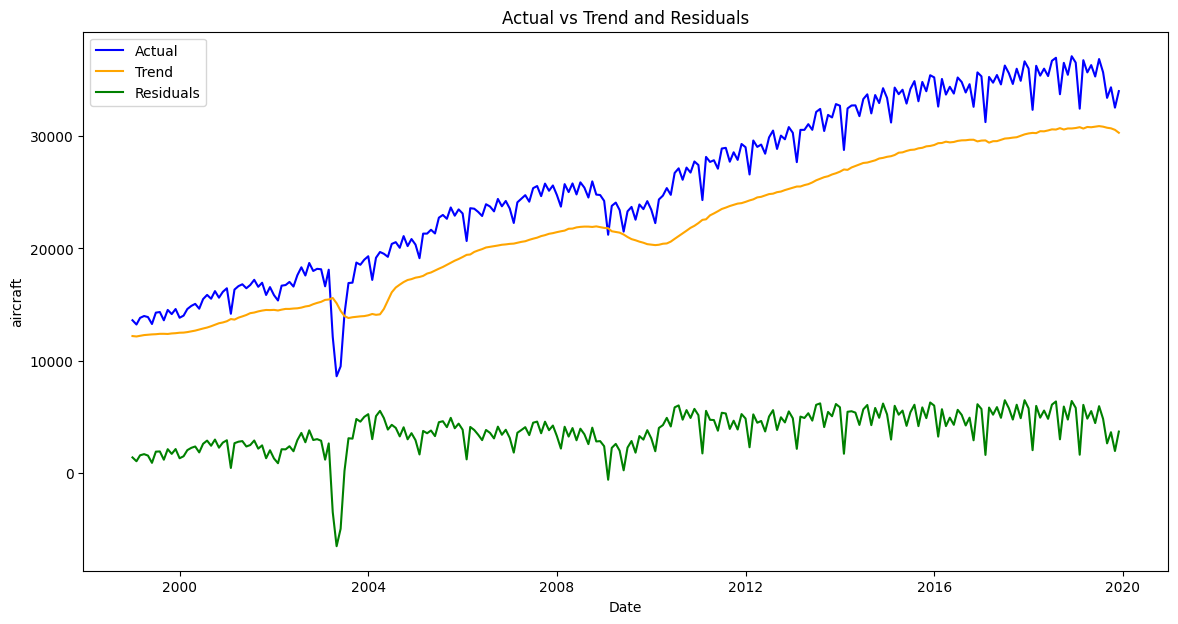

In [8]:
def capture_trend(x, org, trend, detrend, feature):
    # plot
    plt.figure(figsize=(14, 7))
    plt.plot(x, org, label='Actual', color='blue')
    plt.plot(x, trend, label='Trend', color='orange')
    plt.plot(x, detrend, label='Residuals', color='green')
    plt.title('Actual vs Trend and Residuals')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

capture_trend(AIR.index, AIR['Aircraft Total'], AIR['Aircraft Total Trend'], AIR['Aircraft Total Detrend'], 'aircraft')

In [9]:
def check_stationarity(y, d=1, s=12, type='c'):
    # Check stationarity of the original series
    print("Original Series")
    result = adfuller(y, autolag='AIC', regression=type)
    p_value = result[1]
    print(f"ADF: {result[0]}, p-value: {p_value}, Result: {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")
    if p_value < 0.05: return

    # Regular differencing checks
    print(f"Regular Differencing Order {d}")
    timeseries = y.diff(d).dropna()
    result = adfuller(timeseries, autolag='AIC', regression='c')
    p_value = result[1]
    print(f"ADF: {result[0]}, p-value: {p_value}, Result: {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

    # Seasonal differencing checks
    print(f"Seasonal Differencing with Seasonal Period {s}")
    seasonally_differenced_series = y.diff(s).dropna()
    result = adfuller(seasonally_differenced_series, autolag='AIC', regression='c')
    p_value = result[1]
    print(f"ADF: {result[0]}, p-value: {p_value}, Result: {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

check_stationarity(AIR['Aircraft Total Detrend'], type='n')

Original Series
ADF: -0.266298761890469, p-value: 0.5889991163894801, Result: Non-Stationary
Regular Differencing Order 1
ADF: -6.617504118927563, p-value: 6.154318222942596e-09, Result: Stationary
Seasonal Differencing with Seasonal Period 12
ADF: -3.6177585887097723, p-value: 0.005430457920701836, Result: Stationary


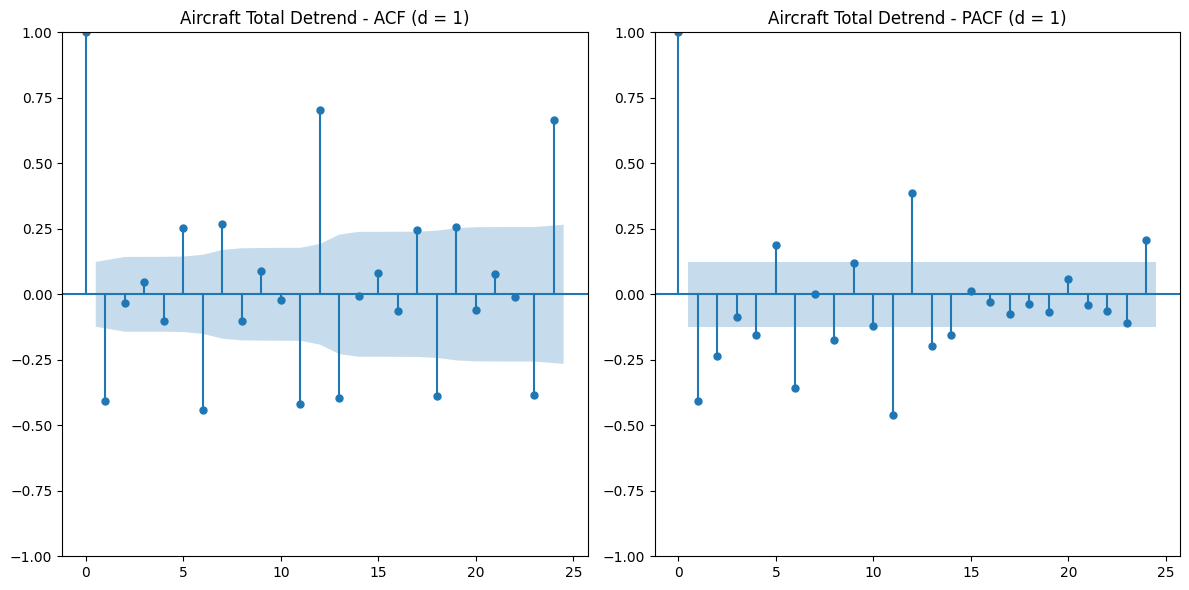

In [10]:
def ACF_PACF(y, title, d=0):
    # Apply differencing based on the specified order
    if d == 0:
        differenced_y = y  # Use the original series if no differencing is needed
    else:
        differenced_y = y.diff(d).dropna()  # Apply differencing based on order

    plt.figure(figsize=(12, 6))

    # Subplot for ACF
    plt.subplot(1, 2, 1)
    plot_acf(differenced_y, ax=plt.gca())
    plt.title(f"{title} - ACF (d = {d})")

    # Subplot for PACF
    plt.subplot(1, 2, 2)
    plot_pacf(differenced_y, ax=plt.gca())
    plt.title(f"{title} - PACF (d = {d})")
    plt.tight_layout()
    plt.show()

    # Calculate ACF and PACF values
    acf_values = acf(differenced_y, nlags=20, fft=True)
    pacf_values = pacf(differenced_y, nlags=20)

    # Create a DataFrame for ACF and PACF values
    acf_pacf_df = pd.DataFrame({
        'ACF': acf_values,
        'PACF': pacf_values
    })

ACF_PACF(AIR['Aircraft Total Detrend'], 'Aircraft Total Detrend', d=1)

In [11]:
# 定义参数范围
p = q = range(0, 3)
P = Q = range(0, 3)
d = D = range(1, 3)
s = [0, 12]

# 创建参数网格
param_grid = ParameterGrid({
    'p': p,
    'd': d,
    'q': q,
    'P': P,
    'D': D,
    'Q': Q,
    's': s
})

In [12]:
best_score = -np.inf
best_aic = np.inf
best_params = None
w1, w2 = 0.8, 0.2 # R2_test 和 R2_train的权重
w3, w4, w5, w6, w7 = 0.0008, 0.0008, 0.0002, 0.0002, 0.001 #RMSE_test，MAE_test，RMSE_train，MAE_train的权重

l_train = AIR['Aircraft Total Detrend'][:216]
l_test = AIR['Aircraft Total Detrend'][216:]

# 网格搜索
for params in param_grid:
    try:
        # 构建 SARIMA 模型并在训练集上拟合
        model = SARIMAX(
            l_train,
            order=(params['p'], params['d'], params['q']),
            seasonal_order=(params['P'], params['D'], params['Q'], params['s']),
            enforce_stationarity=True,
            enforce_invertibility=True
        )

        # 拟合模型
        results = model.fit(disp=False)
        warnings.filterwarnings("ignore")

        # Durbin-Watson test
        dw_statistic = durbin_watson(results.resid)
        if (dw_statistic < 1.5 or dw_statistic > 2.5): # The residuals are autocorrelated
            continue

        l_train_pred = results.predict(start=0, end=len(l_train)-1)
        l_test_pred = results.predict(start=len(l_train), end=len(l_train) + len(l_test) - 1)

        # 获得score
        # R2越大越好，而 MAE和RMSE越小越好
        R2_train = r2_score(l_train_pred, l_train)
        MAE_train = mean_absolute_error(l_train_pred, l_train)
        RMSE_train = sqrt(mean_squared_error(l_train_pred, l_train))

        R2_test = r2_score(l_test_pred, l_test)
        MAE_test = mean_absolute_error(l_test_pred, l_test)
        RMSE_test = sqrt(mean_squared_error(l_test_pred, l_test))

        AIC = results.aic

        score = (w1 * R2_test + w2 * R2_train) / (1 + w3 * RMSE_test + w4 * MAE_test + w5 * RMSE_train + w6 * MAE_train + w7 * AIC)

        # 更新最佳参数：这里以测试集的 R² 和 AIC 为标准
        if score > best_score:
            best_score = score
            best_params = params

            print(f"super parameters: {best_params}, "
            f"training R2: {R2_train:.2f}, testing R2: {R2_test:.2f}, "
            f"training MAE: {MAE_train:.2f}, testing MAE: {MAE_test:.2f}, "
            f"training RMSE: {RMSE_train:.2f}, testing RMSE: {RMSE_test:.2f},"
            f"AIC: {AIC:.2f}")
    except Exception as e:
        continue


print("最佳参数：", best_params)

super parameters: {'D': 1, 'P': 0, 'Q': 0, 'd': 1, 'p': 0, 'q': 0, 's': 12}, training R2: 0.66, testing R2: -0.11, training MAE: 667.81, testing MAE: 926.19, training RMSE: 1107.88, testing RMSE: 1051.24,AIC: 3429.98
super parameters: {'D': 1, 'P': 0, 'Q': 0, 'd': 1, 'p': 0, 'q': 2, 's': 12}, training R2: 0.67, testing R2: -0.08, training MAE: 673.54, testing MAE: 827.34, training RMSE: 1085.67, testing RMSE: 1048.81,AIC: 3424.91
super parameters: {'D': 1, 'P': 0, 'Q': 0, 'd': 2, 'p': 2, 'q': 2, 's': 12}, training R2: 0.68, testing R2: -0.04, training MAE: 693.90, testing MAE: 817.29, training RMSE: 1094.99, testing RMSE: 999.88,AIC: 3411.01
super parameters: {'D': 1, 'P': 0, 'Q': 1, 'd': 2, 'p': 0, 'q': 1, 's': 12}, training R2: 0.74, testing R2: -0.06, training MAE: 576.63, testing MAE: 617.34, training RMSE: 910.87, testing RMSE: 900.98,AIC: 3328.08
super parameters: {'D': 1, 'P': 0, 'Q': 2, 'd': 2, 'p': 0, 'q': 1, 's': 12}, training R2: 0.74, testing R2: 0.08, training MAE: 575.45,

In [ ]:
model_org = SARIMAX(
        AIR['Aircraft Total'],
        order=(1, 2, 0),
        seasonal_order=(2, 1, 0, 12),
        enforce_stationarity=True,
        enforce_invertibility=True
        )

results_org = model_org.fit(disp=False)

dw_statistic_org = durbin_watson(results_org.resid)
print(dw_statistic_org)

y_org = results_org.predict(start=0, end=len(AIR['Aircraft Total'])-1)
y_org = pd.DataFrame(y_org).set_index(date_index)

R2_train_org = r2_score(y_org, AIR['Aircraft Total'])
MAE_train_org = mean_absolute_error(y_org, AIR['Aircraft Total'])
RMSE_train_org = sqrt(mean_squared_error(y_org, AIR['Aircraft Total']))
print(R2_train_org, MAE_train_org, RMSE_train_org)

2.311694037428845
0.9571822436660329 799.1246808546823 1546.5608274703322


# Step 3. Hibrid Model

In [14]:
model = SARIMAX(
        AIR['Aircraft Total Detrend'],
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
        enforce_stationarity=True,
        enforce_invertibility=True
        )

results = model.fit(disp=False)

dw_statistic = durbin_watson(results.resid)
print(dw_statistic)

l_pred = results.fittedvalues
y_hat = pd.DataFrame(l_pred.values + AIR['Aircraft Total Trend'].values).set_index(date_index)

R2_train = r2_score(y_hat, AIR['Aircraft Total'])
MAE_train = mean_absolute_error(y_hat, AIR['Aircraft Total'])
RMSE_train = sqrt(mean_squared_error(y_hat, AIR['Aircraft Total']))
print(R2_train, MAE_train, RMSE_train)

1.6738580535720755
0.9824857720652433 625.4817908767548 971.1537261202675


In [ ]:
joblib.dump(model, r'content/air_best_sarima_model.pkl')

In [ ]:
y_hat.columns = ['Aircraft Total Predict']
AIR = pd.concat([AIR, y_hat], axis=1)
